In [1]:
from comet_ml import Experiment, Optimizer

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

In [3]:
import node

In [4]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [5]:
from tabular_hypernet import Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, basic_train_loop
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface

In [6]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [7]:
DEVICE = 'cuda:1'

## Load data

In [8]:
data = pd.read_csv("../data/Blastchar/churn.csv")

In [9]:
def show_fractions(arr):
    for cls_ in sorted(pd.unique(arr)):
        print(f"{cls_} samples: {(arr==cls_).sum()} ({(arr==cls_).sum()/len(arr)*100:.1f}%)")

processed_data = data.copy()
del processed_data["customerID"]

y_label_enc = LabelEncoder()
y = y_label_enc.fit_transform(processed_data["Churn"].values)
del processed_data["Churn"]

show_fractions(y)

0 samples: 5174 (73.5%)
1 samples: 1869 (26.5%)


In [10]:
label_encoders = {}

for col in processed_data.columns:
    if processed_data[col].dtype == 'object':
        encoder = LabelEncoder()
        processed_data[col] = encoder.fit_transform(processed_data[col].values)
        label_encoders[col] = encoder
        
X = processed_data.values
print(X.shape)

(7043, 19)


### Split it into train and test set

In [11]:
class GenericDataset(torch.utils.data.IterableDataset):
    def __init__(self, data, shuffle: bool=False, samples_no: int=None):
        samples = samples_no or len(data[0])
        self.indices = np.arange(samples)
        self.shuffle = True
        if shuffle:
            self.indices = np.random.permutation(self.indices)
        self.index = 0
        self.max_samples = samples
        self.data_x = data[0].to(torch.float32)
        self.data_y = data[1]

    def __iter__(self):
        if self.shuffle:
            self.indices = np.random.permutation(self.indices)
        while self.index < self.max_samples:
            _idx = self.indices[self.index]
            yield self.data_x[_idx], self.data_y[_idx]
            self.index += 1
    
    def __len__(self):
        return self.data_x.shape[0]

class OversamplingDataset(GenericDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        fractions = {i: (self.data_y==i).sum()/len(self.data_y) for i in self.data_y.unique()}
        print(fractions)
        

def get_dataloader(X, y, size=None, batch_size=32):
    train_dataset = GenericDataset((X, y))
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1)
    
    return trainloader

In [12]:
import imblearn

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100)

X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)


print("Training data:")
show_fractions(y_train)

print("Test data:")
show_fractions(y_test)

Training data:
0 samples: 75 (50.0%)
1 samples: 75 (50.0%)
Test data:
0 samples: 5099 (73.4%)
1 samples: 1844 (26.6%)


## Preprocess

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]

## Benchmark

In [16]:
criterion = torch.nn.CrossEntropyLoss()

def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    results.append({
        "Class": "F1 score",
        "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    results.append({
        "Class": "ROC score",
        "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
    })
    results.append({
        "Class": "Precision",
        "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    results.append({
        "Class": "Recall",
        "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    results.append({
        "Class": "Loss",
        "Metric": criterion(torch.from_numpy(y_score), y_test).item()*100
    })
    return results


def test_model(model_fn, train_data, test_data, label_encoder=None, iters=10):
    X_train, y_train = train_data
    X_test, y_test = test_data
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(test_data))
    
    results = []

    for i in range(iters):
        model = model_fn()

        model.fit(X_train, y_train);    
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

def print_statistics(dframe):
    mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
    print(f"F1: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
    print(f"C-statistics: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="Precision"].mean(), dframe[dframe["Class"]=="Precision"].std()
    print(f"Precision: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="Recall"].mean(), dframe[dframe["Class"]=="Recall"].std()
    print(f"Recall: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")
    
def log_statistics(dframe):
    mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
    logger.info(f"F1: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
    logger.info(f"C-statistics: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="Precision"].mean(), dframe[dframe["Class"]=="Precision"].std()
    logger.info(f"Precision: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

    mean, std = dframe[dframe["Class"]=="Recall"].mean(), dframe[dframe["Class"]=="Recall"].std()
    logger.info(f"Recall: {mean.values[0]:.3f} ~ {std.values[0]:.3f}")

### XGBoost

In [131]:
from xgboost import XGBClassifier

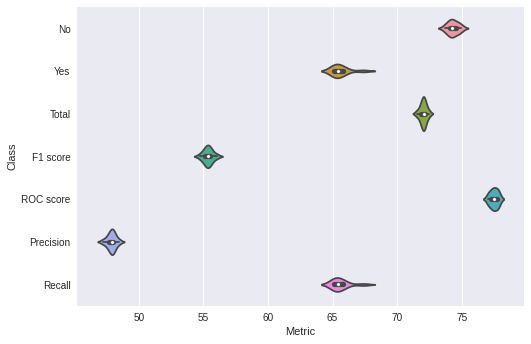

In [132]:
def get_xgboost():
    random_seed = np.random.randint(1024)
    return XGBClassifier(
        verbosity=0,
        random_state=random_seed,
        subsample=0.98,
        use_label_encoder=False)

xgb_dframe = test_model(get_xgboost, 
                        (X_train, y_train), 
                        (X_test, y_test),
                        label_encoder=y_label_enc, iters=10)

In [133]:
print_statistics(xgb_dframe)

F1: 55.353 ~ 0.355
C-statistics: 77.489 ~ 0.292
Precision: 47.875 ~ 0.328
Recall: 65.605 ~ 0.707


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

### Neural network

In [142]:
def simple_network_fn(epochs):
    def _inner():
#         net = SimpleNetwork(X_train.shape[1], outputs=2).to(DEVICE)
        net = torch.nn.Sequential(
#             torch.nn.Dropout(1-15/19),
            torch.nn.Linear(X_train.shape[1], 100),
            torch.nn.ReLU(),
#             torch.nn.Dropout(0.5),
            torch.nn.Linear(100, 2)
        ).to(DEVICE)
        return SimpleSklearnInterface(net, device=DEVICE, epochs=epochs, batch_size=32)
    return _inner

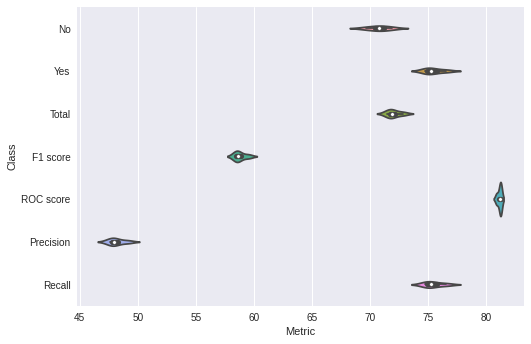

In [143]:
simple_nn_results = test_model(simple_network_fn(150),
                (X_train, y_train), 
                (X_test, y_test),
                y_label_enc, 4)

In [145]:
print_statistics(simple_nn_results)

F1: 58.791 ~ 0.489
C-statistics: 81.163 ~ 0.167
Precision: 48.158 ~ 0.670
Recall: 75.463 ~ 0.801


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

### NODE

In [74]:
from qhoptim.pyt import QHAdam

In [107]:
def node_fn(layer_dims):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], layer_dims, num_layers=1, tree_dim=2, depth=6, flatten_output=False,
                           choice_function=node.entmax15, bin_function=node.entmoid15),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train[:1000], device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/node/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."
/home/wwydmanski/.conda/envs/img_processing/lib/python3.8/site-packages/node/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."
/home/wwydmanski/.conda/en

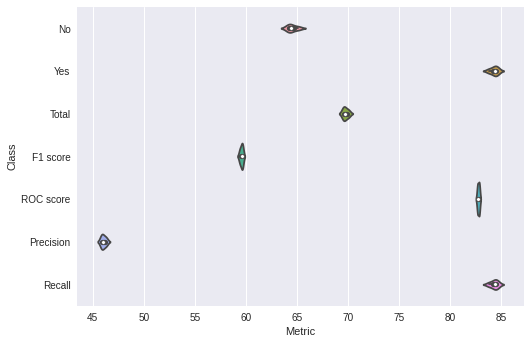

In [146]:
node_results = test_model(node_fn(128),
                (X_train, y_train), 
                (X_test, y_test),
                y_label_enc, 4)

In [148]:
print_statistics(node_results)

F1: 59.550 ~ 0.134
C-statistics: 82.738 ~ 0.093
Precision: 46.044 ~ 0.228
Recall: 84.273 ~ 0.370


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

### Hypernetwork

In [20]:
def network_fn(batch_size):
    def _inner():
        network = Hypernetwork(inp_size=X_train.shape[1], 
                            out_size=y.max().item()+1, 
                            mask_size=15,
                            layers=[128, 128, 128],
                            node_hidden_size=100, 
                            test_nodes=15, device=DEVICE).to(DEVICE)

        network = HypernetworkSklearnInterface(network, device=DEVICE, epochs=1500, batch_size=batch_size)
        return network
    return _inner

In [18]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

In [19]:
X_train.shape

torch.Size([150, 19])

In [ ]:
nn_results = test_model(network_fn(1500),
                (X_train, y_train), 
                (X_test, y_test),
                y_label_enc, 4)

 49%|██████████████████████████████████████▉                                         | 731/1500 [02:32<02:41,  4.77it/s]

In [163]:
print_statistics(nn_results)

F1: 51.015 ~ 2.377
C-statistics: 74.728 ~ 1.471
Precision: 46.972 ~ 1.275
Recall: 55.910 ~ 4.324


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

In [164]:
res

{50:         Class     Metric
 0          No  66.320736
 1         Yes  77.614379
 2       Total  69.307216
 3    F1 score  57.217426
 4   ROC score  78.311167
 5   Precision  45.310016
 6      Recall  77.614379
 7        Loss  57.040131
 8          No  70.119444
 9         Yes  68.082789
 10      Total  69.580873
 11   F1 score  54.206418
 12  ROC score  76.747164
 13  Precision  45.028818
 14     Recall  68.082789
 15       Loss  55.312008
 16         No  59.917760
 17        Yes  76.851852
 18      Total  64.395794
 19   F1 score  53.305629
 20  ROC score  77.189197
 21  Precision  40.803933
 22     Recall  76.851852
 23       Loss  61.701262
 24         No  72.841198
 25        Yes  66.557734
 26      Total  71.179605
 27   F1 score  54.983127
 28  ROC score  77.348116
 29  Precision  46.837869
 30     Recall  66.557734
 31       Loss  53.947181,
 100:         Class     Metric
 0          No  66.849422
 1         Yes  77.342048
 2       Total  69.624082
 3    F1 score  57.385330
 4

In [ ]:
res = {}
for epochs in [50, 100, 150, 200, 300, 500, 700, 1000]:
    nn_results = test_model(network_fn(epochs),
                    (X_train, y_train), 
                    (X_test, y_test),
                    y_label_enc, 4)
    res[epochs] = nn_results
    logger.info(f"Number of epochs: {epochs}")
    log_statistics(res[epochs])

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.86it/s]
2022-05-11 08:28:15.072 | INFO     | __main__:<module>:8 - Number of epochs: 50
/tmp/ipykernel_276146/3812846823.py:79: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
2022-05-11 08:28:15.075 | INFO     | __main__:log_statistics:80 - F1: 54.928 ~ 1.673
/tmp/ipykernel_276146/3812846823.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
2022

In [166]:
for key in res.keys():
    print_statistics(res[key])

F1: 54.928 ~ 1.673
C-statistics: 77.399 ~ 0.659
Precision: 44.495 ~ 2.586
Recall: 72.277 ~ 5.765
F1: 55.029 ~ 1.699
C-statistics: 77.361 ~ 1.500
Precision: 46.169 ~ 1.325
Recall: 68.505 ~ 6.616
F1: 55.498 ~ 0.549
C-statistics: 76.219 ~ 1.721
Precision: 47.115 ~ 3.305
Recall: 68.450 ~ 7.286
F1: 54.086 ~ 1.664
C-statistics: 76.971 ~ 1.411
Precision: 48.783 ~ 1.319
Recall: 60.866 ~ 4.339
F1: 51.632 ~ 1.469
C-statistics: 74.078 ~ 1.890
Precision: 46.172 ~ 0.785
Recall: 58.701 ~ 4.012
F1: 52.213 ~ 0.575
C-statistics: 74.437 ~ 2.121
Precision: 46.732 ~ 3.589
Recall: 59.695 ~ 4.278
F1: 50.184 ~ 3.190
C-statistics: 75.413 ~ 1.848
Precision: 47.884 ~ 2.360
Recall: 53.214 ~ 6.900
F1: 48.936 ~ 1.521
C-statistics: 73.695 ~ 0.945
Precision: 47.102 ~ 1.683
Recall: 51.021 ~ 3.005


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]

#### Hyperparameter optimizations

In [ ]:
hypernet_res = []
for batch_size in [4, 8, 16, 32, 64]:
    start = time.time()

    exp = Experiment(os.environ.get("COMET_KEY"), "blastchar-hypernet")
    exp.log_parameters({"batch_size": batch_size})
    nn_results = test_model(network_fn(batch_size),
                            (X_train, y_train), 
                            (X_test, y_test), 
                            y_label_enc, 1)
    nn_results["Epochs"] = epochs
    plt.title(f"Epochs: {epochs}")

    loss = nn_results[nn_results["Class"]=="Loss"]["Accuracy"]
    accuracy = nn_results[nn_results["Class"]=="Total"]["Accuracy"]
    exp.log_metric("mean_loss", loss.mean())
    exp.log_metric("loss_std", loss.std())
    exp.log_metric("mean_acc", accuracy.mean())
    exp.log_metric("acc_std", accuracy.std())

    exp.log_dataframe_profile(nn_results)
    exp.log_html(figure_to_html())
    plt.show()

    hypernet_res.append(nn_results)

    end = datetime.timedelta(seconds=time.time()-start)
    logger.info(f"{epochs=} done in {str(end)}. Loss: {loss.mean():.3g}+-{loss.std():.3g}. Acc: {accuracy.mean():.1f}+-{accuracy.std():.2f}")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/blastchar-hypernet/88800e08f98b4b0297685774fa4f06a0
COMET INFO:   Parameters:
COMET INFO:     batch_size : 4
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (299.15 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


### TabNet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [149]:
np.array(X_train).shape

(134, 19)

Device used : cuda
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.84536 |  0:00:00s
epoch 1  | loss: 0.70384 |  0:00:00s
epoch 2  | loss: 0.62857 |  0:00:00s
epoch 3  | loss: 0.5942  |  0:00:00s
epoch 4  | loss: 0.59312 |  0:00:00s
epoch 5  | loss: 0.54083 |  0:00:00s
epoch 6  | loss: 0.52085 |  0:00:00s
epoch 7  | loss: 0.50849 |  0:00:00s
epoch 8  | loss: 0.50789 |  0:00:00s
epoch 9  | loss: 0.47963 |  0:00:00s
epoch 10 | loss: 0.4389  |  0:00:00s
epoch 11 | loss: 0.43232 |  0:00:00s
epoch 12 | loss: 0.40346 |  0:00:00s
epoch 13 | loss: 0.3868  |  0:00:00s
epoch 14 | loss: 0.40405 |  0:00:00s
epoch 15 | loss: 0.39284 |  0:00:00s
epoch 16 | loss: 0.39727 |  0:00:00s
epoch 17 | loss: 0.36165 |  0:00:00s
epoch 18 | loss: 0.38959 |  0:00:00s
epoch 19 | loss: 0.40563 |  0:00:00s
epoch 20 | loss: 0.40416 |  0:00:00s
epoch 21 | loss: 0.31999 |  0:00:00s
epoch 22 | loss: 0.3385  |  0:00:00s
epoch 23 | loss: 0.32313 |  0:00:00s
epoch 24 | loss: 0.3

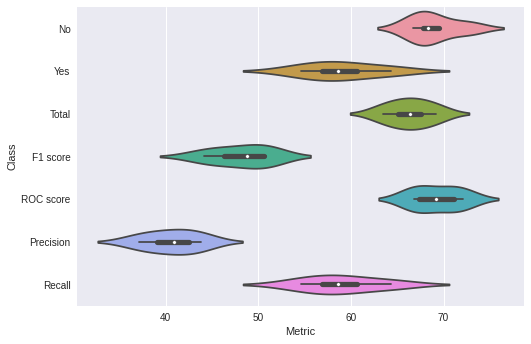

In [150]:
def tabnet_fn():
    clf = TabNetClassifier(seed=np.random.randint(1024))
    return clf

tabnet_results = test_model(tabnet_fn,
                    (np.array(X_train), np.array(y_train)), 
                    (X_test, y_test),
                    y_label_enc, 4)

In [151]:
print_statistics(tabnet_results)

F1: 48.135 ~ 3.153
C-statistics: 69.298 ~ 2.537
Precision: 40.670 ~ 2.924
Recall: 59.028 ~ 4.102


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]